# Méthodes de ML supervisé appliquées au scoring de risque pays 

Dernière modification : 27/03/2024


Plan : 

1) Récupération et formatage de données pour l'entrainement de prototypes 
2) Visualisation des données 
3) Première approche par arbres de décision avec Scikit Learn
4) Deuxième approche : par réseaux de neurones 
5) Quelques perspectives




## Récupération et formatage de données pour l'entrainement de prototypes 


Données open source sur le site de la Banque Mondiale : https://data.worldbank.org/topic/public-sector (Public Sector Indicators, WB 2024).

**L'idée est de disposer d'une batterie d'indicateurs à pays et année donnés.**

Ici nous regardons quatre indicateurs (Contrôle de la corruption, Qualité du cadre règlementaire, Efficacité du gouvernement, Indicateur de stabilité politique et de violence), pour les pays disponibles. Ces indicateurs ont été choisis de manière discrétionnaire car ils sont assez bien renseignés dans la base de données, et peuvent être pertinents par rapport au rating que l'on souhaite estimer. 

Quelques pays ont été sélectionnés arbitrairement pour l'étude : 
- USA
- Argentine
- Bengladesh
- Norvège
- Burkina Faso
- Canada
- Suisse
- Allemagne
- Haïti
- Mali
- Sénégal

Ce choix vise à prendre en compte des pays structurellement différents, pour lesquels les indicateurs considérés sont assez bien renseignés. Il pourrait être étendu à n'importe quelle liste de pays. On pourrait ainsi imaginer entraîner un modèle par groupes de pays pré-définis, pour éviter les irrégularités statistiques (Japon par exemple). 

Le rating considéré est un indicateur de qualité de la gestion de la dette, facile à récupérer dans la base de données considérée (même si cela n'est pas un rating de risque souverain).
Il s'agit d'une note sur 6, que l'on multipliera par 50 pour avoir des entiers. On a donc au maximum 61 modalités, même s'il y en a moins en pratique (5 pour l'échantillon étudié par la suite).

L'approche est reproductible pour des times series de données de meilleure qualité. 


Import des modules de traitement de données :

In [39]:
import pandas as pd
import numpy as np

Paramètres : 

In [40]:
first_year = 2004

use_countrylist = True

country_list=["USA","ARG","BGD","NOR","BFA","CAN","CHE","DEU","HTI","MLI","SEN"]

all_countries = np.array({'LKA', 'EST', 'ZWE', 'MNP', 'GIN', 'SLE', 'IRL', 'PRT', 'CZE', 'COD', 'BEN', 'ARG', 'IMN', 'BMU', 'CHI', 'WSM', 'FSM', 'QAT', 'HKG', 'SST', 'MLI', 'TUR', 'VUT', 'ZMB', 'EUU', 'NGA', 'ARE', 'PAN', 'LMY', 'SWZ', 'VEN', 'PST', 'MKD', 'TTO', 'PSS', 'SXM', 'COG', 'USA', 'LTE', 'MMR', 'SVK', 'MEA', 'MNA', 'IBD', 'STP', 'TEC', 'SAU', 'NLD', 'CEB', 'YEM', 'BGR', 'GNQ', 'CPV', 'LSO', 'SYC', 'MNG', 'OSS', 'VIR', 'DEU', 'PSE', 'GAB', 'ISR', 'MDV', 'POL', 'LCN', 'KGZ', 'KHM', 'ZAF', 'FJI', 'LCA', 'PRE', 'ARM', 'MRT', 'NPL', 'AZE', 'NZL', 'XKX', 'ETH', 'IRN', 'BDI', 'GRC', 'PNG', 'BGD', 'BEL', 'DZA', 'LIE', 'LUX', 'MOZ', 'MUS', 'NRU', 'MAF', 'SMR', 'IBT', 'SSD', 'GMB', 'SUR', 'TGO', 'AUS', 'EAS', 'TJK', 'LMC', 'UGA', 'ITA', 'LVA', 'PRI', 'IDX', 'HPC', 'CYM', 'FRO', 'CHL', 'SDN', 'SOM', 'LTU', 'CMR', 'MHL', 'LBR', 'NIC', 'NER', 'ARB', 'BHS', 'BTN', 'SRB', 'EMU', 'RUS', 'LBN', 'TLA', 'AND', 'IND', 'WLD', 'AFE', 'ALB', 'BHR', 'ATG', 'DOM', 'ECA', 'GEO', 'GUY', 'KOR', 'TUN', 'PAK', 'VCT', 'TKM', 'CUW', 'ECS', 'NAC', 'RWA', 'GIB', 'MLT', 'OED', 'SGP', 'AFG', 'MAC', 'HRV', 'UKR', 'IDB', 'KNA', 'PRY', 'DJI', 'AFW', 'JAM', 'FCS', 'SLB', 'SLV', 'TLS', 'GRD', 'VGB', 'PHL', 'SVN', 'LAC', 'KAZ', 'CYP', 'IDA', 'NOR', 'MWI', 'JOR', 'FIN', 'SWE', 'LAO', 'MIC', 'SSF', 'BOL', 'LIC', 'GNB', 'ISL', 'JPN', 'MCO', 'PLW', 'PYF', 'CAF', 'BFA', 'TMN', 'EGY', 'GRL', 'CIV', 'CSS', 'AUT', 'BRA', 'OMN', 'HIC', 'LBY', 'TEA', 'MYS', 'ERI', 'CHE', 'COM', 'PRK', 'GHA', 'BLZ', 'GTM', 'MDG', 'MEX', 'CHN', 'KWT', 'GBR', 'NCL', 'EAR', 'KIR', 'PER', 'ASM', 'ESP', 'NAM', 'VNM', 'SYR', 'LDC', 'EAP', 'IRQ', 'UZB', 'THA', 'IDN', 'TSA', 'CRI', 'COL', 'BWA', 'MAR', 'ECU', 'SAS', 'ABW', 'TON', 'MDA', 'TCD', 'TUV', 'TSS', 'SEN', 'CAN', 'HND', 'HUN', 'HTI', 'UMC', 'MNE', 'TZA', 'GUM', 'BRB', 'FRA', 'AGO', 'BIH', 'BRN', 'DMA', 'ROU', 'BLR', 'INX', 'KEN', 'DNK', 'SSA', 'CUB', 'URY', 'TCA'},
      dtype=object)


indic_list=["CC.EST","RQ.EST","GE.EST","PV.EST"] 

target_code="IQ.CPA.DEBT.XQ"

target_name="CPIA debt policy rating"

feature_names=["Control of Corr.",
                "Regul. Quality",
                "Gov. Effectiveness",
                "Pol. Stability"]

Il est à noter que la donnée est parfois lacunaire (présence de "nan" dans les tableaux). On extrait donc les couples pays/année pour lesquels l'on dispose des 4 indicateurs et du rating. 

En effet, avec 11 pays et sur 18 ans de données on devrait observer 198 lignes, alors que le tableau suivant n'en a que 90. 

Formatage des données :
- renvoie un tableau de n-uplets des indicateurs sélectionnés par pays et par année ;
- renvoie une liste de ratings, en utilisant comme proxy la note de gestion de dette de la Banque Mondiale. La position correspond aux positions des n-uplets précédents). Constitue les labels/modalités pour l'apprentissage supervisé.


In [41]:

df = pd.read_csv('data/raw_data.csv')

if use_countrylist :
    selected_countries = df.loc[df['Country Code'].isin(country_list)] 
else:
    selected_countries = df 

selected_countries_indicators = selected_countries.loc[selected_countries['Indicator Code'].isin(indic_list+[target_code])]
selected_countries_indicators = selected_countries_indicators.drop(['Country Name','Indicator Name'], axis=1)
selected_countries_indicators = selected_countries_indicators.drop(selected_countries_indicators.columns[-1], axis=1)
df_melted = pd.melt(selected_countries_indicators, id_vars=['Country Code',"Indicator Code"], var_name='Date', value_name="Value")
contries_date_indic = df_melted.pivot(index=['Country Code', 'Date'], columns='Indicator Code', values='Value').reset_index()
contries_date_indic['Date'] = pd.to_numeric(contries_date_indic['Date'])
contries_date_indic = contries_date_indic[contries_date_indic['Date'] > first_year]

#on retire les lignes avec des valeurs manquantes
contries_date_indic = contries_date_indic.dropna()

#affichage du df indic + target
print(contries_date_indic)

#retirer les première colonne 
contries_date_indic.columns.name = None
contries_date_indic = contries_date_indic.drop(['Country Code','Date'], axis=1)

#création TARGET & DATA
df_target = contries_date_indic[target_code]
target = df_target.to_numpy()
target = (target * 10).astype(int)

df_data=contries_date_indic.drop([target_code], axis=1)
data=df_data.to_numpy()

len(data)==len(target)

Indicator Code Country Code  Date    CC.EST    GE.EST  IQ.CPA.DEBT.XQ  \
108                     BFA  2005 -0.105527 -0.604899             4.5   
109                     BFA  2006 -0.310118 -0.800564             4.0   
110                     BFA  2007 -0.329598 -0.770006             4.0   
111                     BFA  2008 -0.309015 -0.530284             4.0   
112                     BFA  2009 -0.345607 -0.617470             4.0   
..                      ...   ...       ...       ...             ...   
625                     SEN  2018 -0.046840 -0.329337             4.5   
626                     SEN  2019 -0.003814 -0.134348             4.0   
627                     SEN  2020 -0.007386 -0.061386             4.0   
628                     SEN  2021  0.042111  0.021849             4.0   
629                     SEN  2022 -0.028728 -0.001249             4.0   

Indicator Code    PV.EST    RQ.EST  
108            -0.062653 -0.456179  
109             0.155800 -0.396016  
110         

True

## Visualisation des données

Import du module de visualisation : 

In [42]:
import matplotlib.pyplot as plt

Visualisation par projection sur les deux premiers axes : 

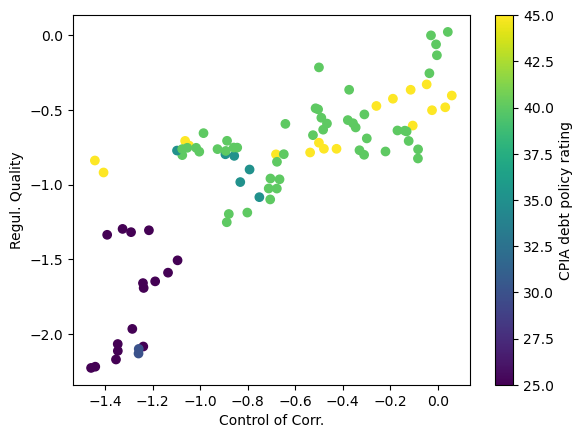

In [43]:
_, ax = plt.subplots()
scatter = ax.scatter(data[:, 0], data[:, 1], c=target, cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('CPIA debt policy rating')

ax.set(xlabel=feature_names[0], ylabel=feature_names[1])
plt.show()

Visualisation par projection sur les trois premiers axes : 

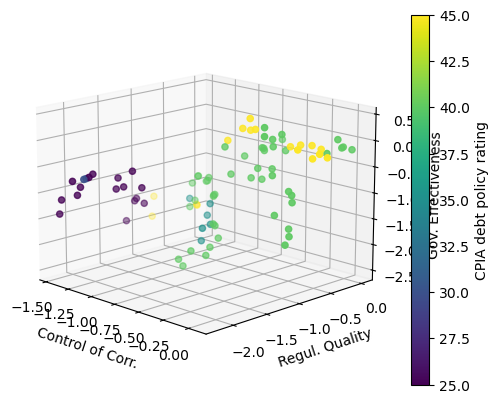

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=target, cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('CPIA debt policy rating')

ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])

ax.view_init(elev=15, azim=-45)  
ax.dist = 5

plt.show()

## Première approche par arbres de décision avec Scikit Learn

La bibliothèque Scikit Learn permet l'utilisation de fonctions pré-implémentées pour les arbres de classification. 

Ici nous utiliserons l'algorithme CART pour la classification, car il est implémenté de manière optimisée : https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

Il utilise pour la classification le critère de Gini, afin de sélectionner la meilleure manière de partitionner l'espace, et construit l'arbre de décision en itérant ce processus. 

L'entrainement du modèle consiste donc en la partition de l'espace (de dimension égale à la taille du n-uplet d'indicateurs dont nous disposons pour chaque pays), afin de constituer des domaines au sein desquels les ratings sont homogènes. Plusieurs modalités peuvent ainsi être considérées, ce qui ne nous limite pas à des ratings binaires. 

Lorsque l'on obtient une nouvelle donnée pays/année (ex. Angola 2024), le rating de la région dans laquelle se situe le point dans l'espace des indicateurs considérés constituera notre prédiction de rating.


Import des modules utiles :

In [45]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.inspection import DecisionBoundaryDisplay

In [46]:
import graphviz

In [47]:
#Déclaration de l'arbre de décision
clf = DecisionTreeClassifier(max_depth=3)

#Entrainement de l'abre de décision 
clf.fit(data, target)

DecisionTreeClassifier(max_depth=3)

Visualisation de l'arbre : 

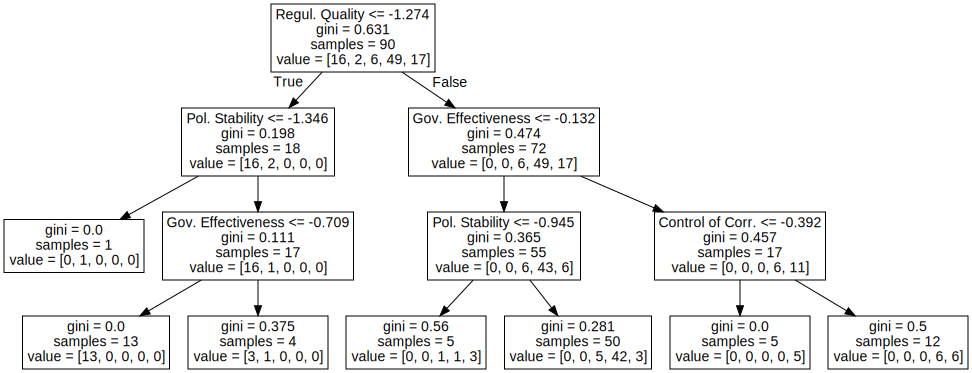

In [48]:
dot_data = export_graphviz(clf, out_file=None, feature_names=feature_names)  
graph = graphviz.Source(dot_data)  
graph 

La profondeur optimale peut être calculée par l'algorithme : 

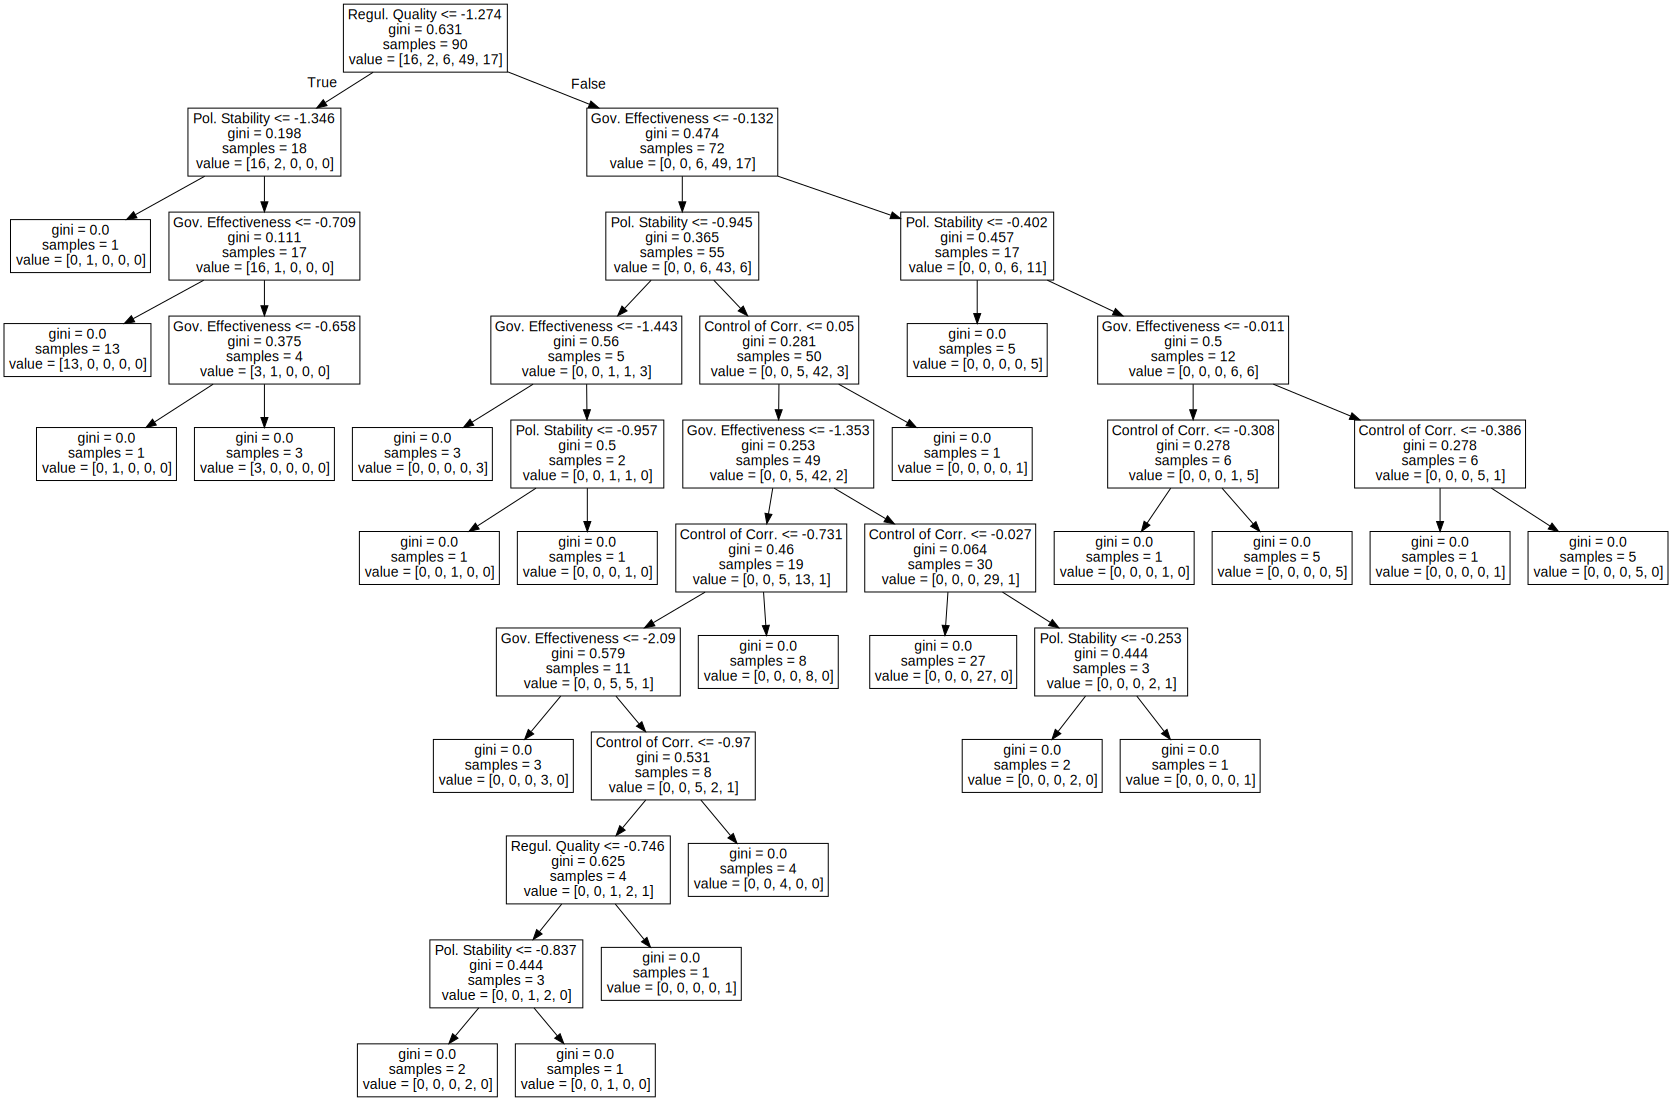

In [49]:
clf = DecisionTreeClassifier()
clf.fit(data, target)

dot_data = export_graphviz(clf, out_file=None, feature_names=feature_names)  
graph = graphviz.Source(dot_data)  
graph 

On peut visualiser graphiquement le résultat obtenu :

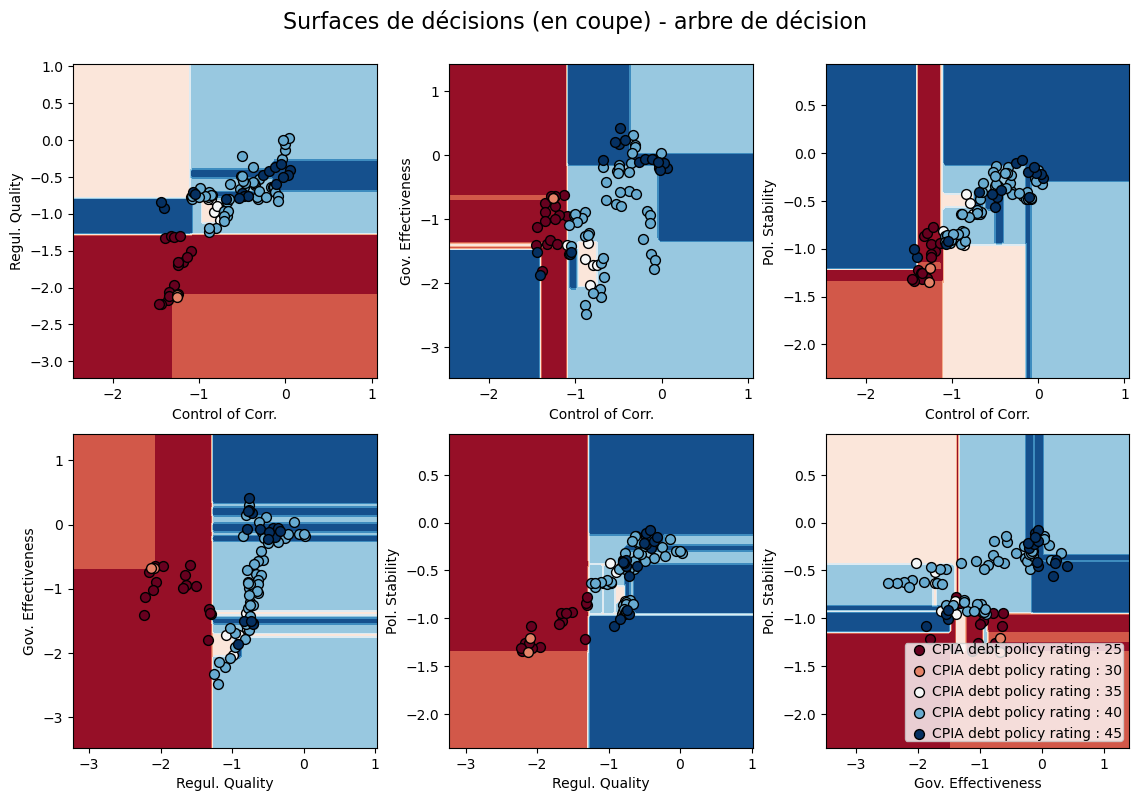

In [50]:
# Use predefined colormap for custom colors
n_classes = list(set(target))
n_classes.sort()
custom_colors = plt.cm.RdBu(np.linspace(0, 1, len(n_classes)))

# Paramètres
plot_step = 0.02

plt.figure(figsize=(12, 8))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    X = data[:, pair]
    y = target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdBu,
        response_method="predict",
        ax=ax,
        xlabel=feature_names[pair[0]],
        ylabel=feature_names[pair[1]],
    )
    
    for i, color in zip(n_classes, custom_colors):
        idx = np.where(y == i)
        ax.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color.reshape(1, -1),  # Ensure color is a 2D array
            edgecolor="black",
            s=50,
            label=f"{target_name} : {i}" 
        )

plt.suptitle("Surfaces de décisions (en coupe) - arbre de décision", y=1.02, fontsize=16)
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")


## Deuxième approche : par réseaux de neurones 

On utilise l'approche par réseaux de neurones implémentée dans Sklearn : https://scikit-learn.org/stable/modules/neural_networks_supervised.html#

La fonction en question entraine un réseau de neurones par _backpropagation_ (descente de gradient stochastique). 

Elle permet une approche de Machine Learning supervisé pour faire de la classification, ce qui est pertinent dans le cas d'espèce.

Import du module :

In [51]:
from sklearn.neural_network import MLPClassifier

Normalisation des indicateurs : 

In [52]:
scaler_data = preprocessing.StandardScaler().fit(data)

data_scaled = scaler_data.transform(data)

In [53]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(data_scaled, target)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

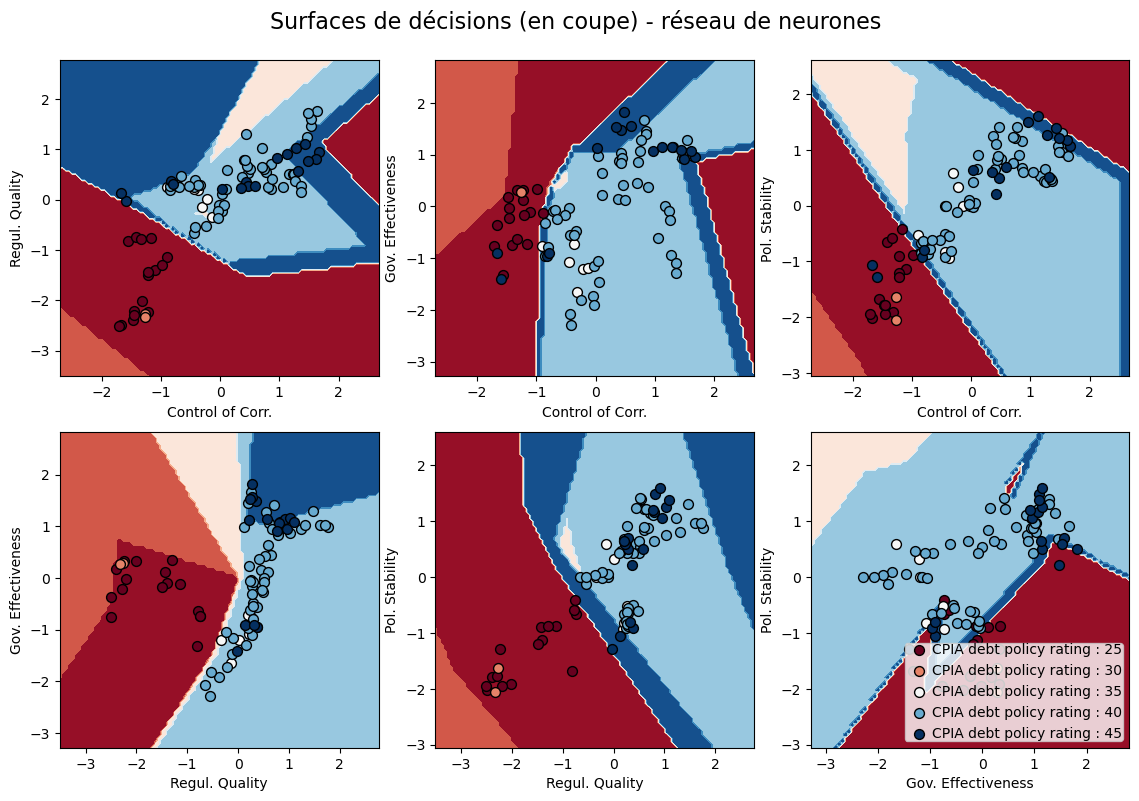

In [54]:
# Use predefined colormap for custom colors
custom_colors = plt.cm.RdBu(np.linspace(0, 1, len(n_classes)))

# Paramètres
plot_step = 0.02

plt.figure(figsize=(12, 8))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    X = data_scaled[:, pair]
    y = target

    # Train
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000).fit(X, y)

    # Decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdBu,
        response_method="predict",
        ax=ax,
        xlabel=feature_names[pair[0]],
        ylabel=feature_names[pair[1]],
    )
    
    for i, color in zip(n_classes, custom_colors):
        idx = np.where(y == i)
        ax.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color.reshape(1, -1),  # Ensure color is a 2D array
            edgecolor="black",
            s=50,
            label=f"{target_name} : {i}" 
        )

plt.suptitle("Surfaces de décisions (en coupe) - réseau de neurones", y=1.02, fontsize=16)
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")



## Quelques perspectives

Concernant le modèle et les données :

- DataSet d'entrainement : **grand nombre de points nécessaire**. Moralement on pourrait espérer 150 pays * 20 ans de données (indicateurs et rating), soit 3k points ?  

- **Sélection des indicateurs les plus pertinents** (PCA ?). Un grand nombre demandera de plus grandes capacités de calcul, et des indicateurs non pertinents pourraient rendre les modèles sous-optimaux.

- Entrainement par **validation croisée** avec sklearn.cross_validation.cross_val_score par exemple -> on aurait un indicateur de scoring du meilleur modèle.

- Optimisation du modèle par réseau de neurones, **en affinant les choix par défaut** :
    - solver='lbfgs', 
    - alpha=1e-5, 
    - hidden_layer_sizes=(5, 2), 
    - random_state=1

Questions  : 

- Fréquence du rating : annuel ?

- Sujets de qualité de la donnée


